In [9]:
import sys
import pandas as pd # dataframes
import seaborn as sns # plots
import matplotlib.pyplot as plt # plots
import scipy.sparse as sp
from scipy.sparse import csr_matrix # matrices
import os # system
import glob # global system
from os import listdir
from os.path import isfile, join
import random
import numpy as np # numbers
print(sys.executable)

/software/isg/languages/Python/Python-3.11.10-jupyter/exec/bin/python3


In [10]:
# set base directory
base_dir = "/lustre/scratch126/casm/team274sb/lr26/allele-integrator-pbfix/GenotypingResults/"

In [13]:
import pandas as pd

# Define file path
patient_file = base_dir + "patient-bulk-DNA_genotypeCheck.tsv"

# Load the file into a DataFrame
patient_df = pd.read_csv(patient_file, sep="\t", header=None)  # Use header=0 if the file has a header row

# Display the first few rows
print(patient_df.head())




   0      1  2  3   4  5   6
0  1  17365  0  5   0  0   5
1  1  17385  4  0  10  0  14
2  1  69270  0  0   0  0   0
3  1  69511  0  0   0  0   0
4  1  69761  0  0   0  0   0


In [37]:
df

,0,1,2,3,4,5,6
0,1,17365,0,5,0,0,5
1,1,17385,4,0,10,0,14
2,1,69270,0,0,0,0,0
3,1,69511,0,0,0,0,0
4,1,69761,0,0,0,0,0
...,...,...,...,...,...,...,...
61733,9,138175475,29,6,0,0,35
61734,9,138175673,0,13,0,15,28
61735,9,138175883,0,0,27,0,27
61736,9,138176267,0,0,0,7,7


In [14]:
# Read the TSV file without headers
df = pd.read_csv(patient, sep="\t", header=None)  

# Select only the first two columns (chr and pos)
bed_df = df.iloc[:, [0, 1]].copy()  # Column index 1 = 'chr', index 2 = 'pos'

# Ensure chromosome names are prefixed correctly
bed_df.iloc[:, 0] = "chr" + bed_df.iloc[:, 0].astype(str)  

# Convert 'pos' to BED format (0-based start, 1-based end)
bed_df['start'] = bed_df.iloc[:, 1]-1    # BED end is 1-based
bed_df['end'] = bed_df.iloc[:, 1]
# Keep only 'chr', 'start', 'end'
bed_df = bed_df.iloc[:, [0, 2, 3]]  

# Save as a BED file (no headers, no index)
bed_df.to_csv("patient_output.bed", sep="\t", index=False, header=False)


/software/isg/languages/Python/Python-3.11.10-jupyter/exec/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


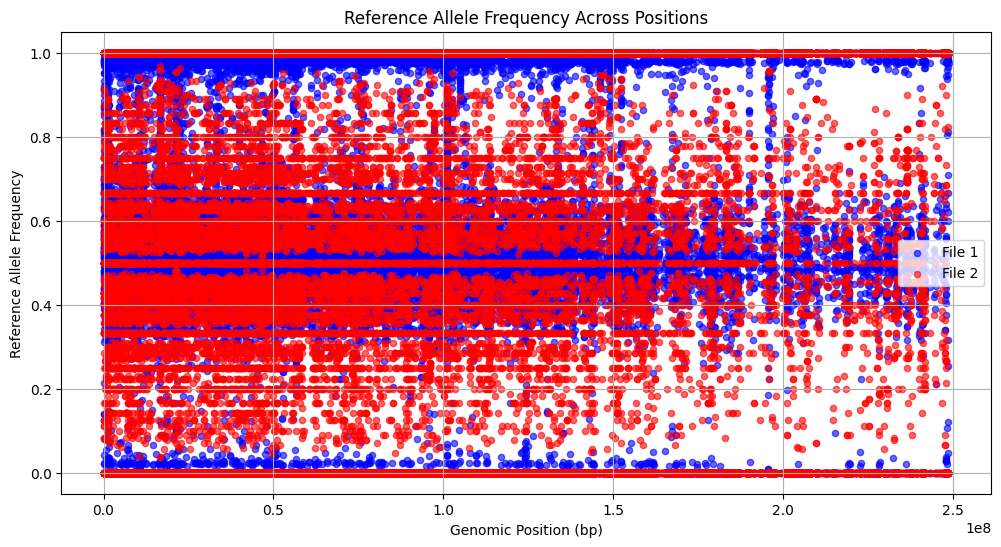

In [17]:
# Load both files
file1 = (base_dir + "patient_fin.vcf")  # Replace with actual filename
file2 = (base_dir + "s1A01_fin.vcf")  # Replace with actual filename

df1 = pd.read_csv(file1, sep="\t", header=None, names=["CHROM", "POS", "REF", "ALT", "AD", "REF_FREQ", "ALT_FREQ", "OTHER_FREQ", "OTHER1_FREQ"])
df2 = pd.read_csv(file2, sep="\t", header=None, names=["CHROM", "POS", "REF", "ALT", "AD", "REF_FREQ", "ALT_FREQ", "OTHER_FREQ", "OTHER1_FREQ"])

# Merge files on CHROM and POS to compare values
merged_df = pd.merge(df1, df2, on=["CHROM", "POS"], suffixes=("_file1", "_file2"))

# Sort by position for better plotting
merged_df = merged_df.sort_values(by="POS")

# Plot Reference Allele Frequencies
plt.figure(figsize=(12, 6))

plt.scatter(merged_df["POS"], merged_df["REF_FREQ_file1"], color="blue", label="File 1", alpha=0.6, s=20)
plt.scatter(merged_df["POS"], merged_df["REF_FREQ_file2"], color="red", label="File 2", alpha=0.6, s=20)

plt.xlabel("Genomic Position (bp)")
plt.ylabel("Reference Allele Frequency")
plt.title("Reference Allele Frequency Across Positions")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [22]:
import numpy as np
import pandas as pd


def compute_zygosity_similarity(file1, file2):
    """
    Computes the similarity between two files based on shared zygosity 
    (homozygous or heterozygous) rather than raw allele frequencies.
    
    Parameters:
        file1 (str): Path to the first file.
        file2 (str): Path to the second file.
    
    Returns:
        float: Zygosity similarity score.
    """
    # Read files into pandas
    df1 = pd.read_csv(file1, sep="\t", header=None, 
                      names=["CHROM", "POS", "REF", "ALT", "AD", "REF_FREQ", "ALT_FREQ", "OTHER_FREQ", "OTHER_FREQ1"])
    
    df2 = pd.read_csv(file2, sep="\t", header=None, 
                      names=["CHROM", "POS", "REF", "ALT", "AD", "REF_FREQ", "ALT_FREQ", "OTHER_FREQ", "OTHER_FREQ1"])

    # Merge files on CHROM and POS
    merged_df = pd.merge(df1, df2, on=["CHROM", "POS"], suffixes=("_file1", "_file2"))

    # Fill NaN values with zero
    merged_df.fillna(0, inplace=True)

    # Determine the most abundant allele frequency at each site
    merged_df["MAF_file1"] = merged_df[["REF_FREQ_file1", "ALT_FREQ_file1", "OTHER_FREQ_file1"]].max(axis=1)
    merged_df["MAF_file2"] = merged_df[["REF_FREQ_file2", "ALT_FREQ_file2", "OTHER_FREQ_file2"]].max(axis=1)

    # Define zygosity categories: Homozygous (≥ 0.9 or ≤ 0.1) vs. Heterozygous (0.3 - 0.7)
    def determine_zygosity(freq):
        if freq >= 0.9 or freq <= 0.1:
            return "HOMO"
        elif 0.3 <= freq <= 0.7:
            return "HET"
        else:
            return "OTHER"

    merged_df["ZYGOSITY_file1"] = merged_df["MAF_file1"].apply(determine_zygosity)
    merged_df["ZYGOSITY_file2"] = merged_df["MAF_file2"].apply(determine_zygosity)

    # Compute similarity as proportion of positions with matching zygosity
    shared_zygosity = (merged_df["ZYGOSITY_file1"] == merged_df["ZYGOSITY_file2"]).sum()
    total_positions = len(merged_df)

    similarity_score = shared_zygosity / total_positions

    return similarity_score


In [23]:
file1 = base_dir + "patient_fin.vcf"
file2 = base_dir + "s1A01_fin.vcf"
file3 = base_dir + "s1A02_fin.vcf"
file4 = base_dir + "s2B01_fin.vcf"
file5 = base_dir + "s1B01_fin.vcf"
file6 = base_dir + "s1C01_fin.vcf"
file7 = base_dir + "s1B02_fin.vcf"
file8 = base_dir + "mom_fin.vcf"

In [24]:
similarity_score = compute_zygosity_similarity(file1, file2)
print(f"Shared zygosity patient tumor WGS - 1A01 patient tumor: {similarity_score:.4f}")
similarity_score1 = compute_zygosity_similarity(file1, file3)
print(f"Shared zygosity patient tumor WGS - 1A02 patient tumor: {similarity_score1:.4f}")
similarity_score2 = compute_zygosity_similarity(file1, file4)
print(f"Shared zygosity patient tumor WGS - 2B01 patient tumor: {similarity_score2:.4f}")
similarity_score3 = compute_zygosity_similarity(file1, file5)
print(f"Shared zygosity patient tumor WGS - 1B01 patient tumor: {similarity_score3:.4f}")
similarity_score4 = compute_zygosity_similarity(file1, file6)
print(f"Shared zygosity patient tumor WGS - 1B02 patient blood: {similarity_score4:.4f}")
similarity_score5 = compute_zygosity_similarity(file1, file7)
print(f"Shared zygosity patient tumor WGS - 1C01 mom blood: {similarity_score5:.4f}")
similarity_score6 = compute_zygosity_similarity(file1, file8)
print(f"Shared zygosity patient tumor WGS - mom WGS: {similarity_score6:.4f}")
similarity_score7 = compute_zygosity_similarity(file7, file8)
print(f"Shared zygosity mom WGS - mom blood 1C01: {similarity_score7:.4f}")
similarity_score8 = compute_zygosity_similarity(file5, file6)
print(f"Shared zygosity patient tumor 1B01 - patient tumor 1B02: {similarity_score8:.4f}")
similarity_score9 = compute_zygosity_similarity(file5, file7)
print(f"Shared zygosity patient tumor 1B01 - mom blood 1C01: {similarity_score9:.4f}")

Shared zygosity patient tumor WGS - 1A01 patient tumor: 0.8938
Shared zygosity patient tumor WGS - 1A02 patient tumor: 0.8985
Shared zygosity patient tumor WGS - 2B01 patient tumor: 0.8847
Shared zygosity patient tumor WGS - 1B01 patient tumor: 0.9543
Shared zygosity patient tumor WGS - 1B02 patient blood: 0.9631
Shared zygosity patient tumor WGS - 1C01 mom blood: 0.6512
Shared zygosity patient tumor WGS - mom WGS: 0.6677
Shared zygosity mom WGS - mom blood 1C01: 0.9633
Shared zygosity patient tumor 1B01 - patient tumor 1B02: 0.9686
Shared zygosity patient tumor 1B01 - mom blood 1C01: 0.6600


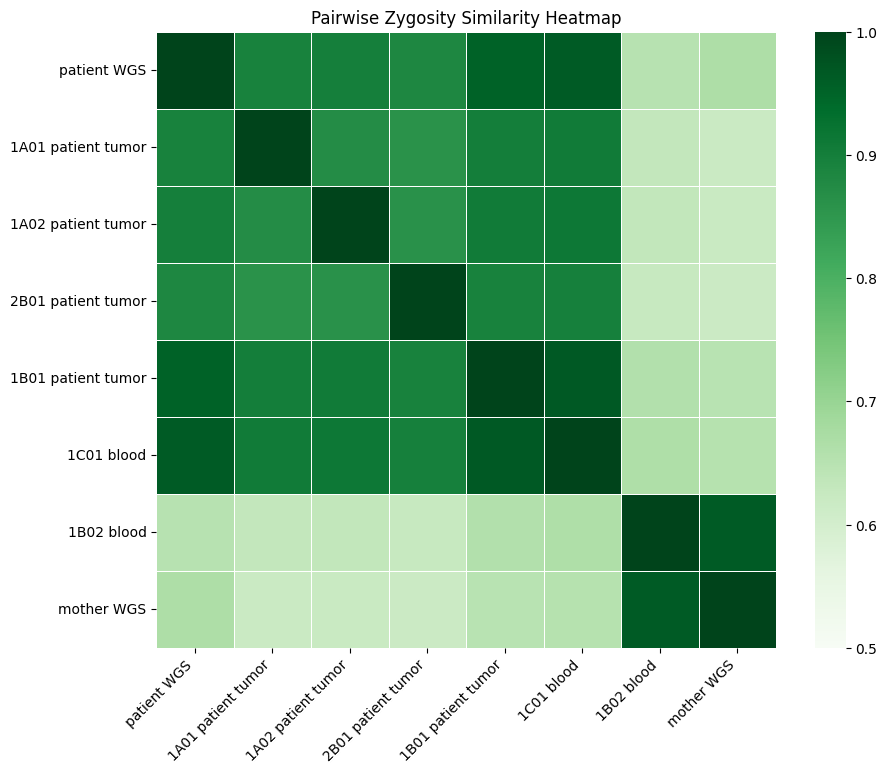

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

files = {
    "patient WGS": base_dir + "patient_fin.vcf",
    "1A01 patient tumor": base_dir + "s1A01_fin.vcf",
    "1A02 patient tumor": base_dir + "s1A02_fin.vcf",
    "2B01 patient tumor": base_dir + "s2B01_fin.vcf",
    "1B01 patient tumor": base_dir + "s1B01_fin.vcf",
    "1C01 blood": base_dir + "s1C01_fin.vcf",
    "1B02 blood": base_dir + "s1B02_fin.vcf",
    "mother WGS": base_dir + "mom_fin.vcf"
}

# Initialize a similarity matrix
samples = list(files.keys())
similarity_matrix = pd.DataFrame(index=samples, columns=samples, dtype=float)

# Compute pairwise zygosity similarity
for s1, s2 in itertools.combinations(samples, 2):
    similarity_score = compute_zygosity_similarity(files[s1], files[s2])
    
    similarity_matrix.loc[s1, s2] = similarity_score
    similarity_matrix.loc[s2, s1] = similarity_score  # Symmetric matrix

# Fill diagonal with 1 (self-similarity)
np.fill_diagonal(similarity_matrix.values, 1.0)

# Plot the Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix.astype(float), annot=False, cmap="Greens", linewidths=0.5, vmin=0.5, vmax=1)
plt.title("Pairwise Zygosity Similarity Heatmap")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()
